In [1]:
import pandas as pd
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt

plt.figure()
plt.close()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams.update({'font.size': 22})

In [4]:
from modules import io

config_file = './config/googlenet_train150k_clean.yaml'
config = io.load_yaml(config_file)

In [5]:
import factories.model_factory as model_factory

model = model_factory.get(config)
model.load()

/home/marsdenlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/marsdenlab/projects/seg_regression/components/models/nn.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-pa

pool 1 Tensor("googlenet/max_pool:0", shape=(?, 79, 79, 64), dtype=float32)
pool_2 Tensor("googlenet/max_pool_1:0", shape=(?, 39, 39, 192), dtype=float32)
pool 3 Tensor("googlenet/max_pool_2:0", shape=(?, 19, 19, 480), dtype=float32)
pool side Tensor("googlenet/avg_pool:0", shape=(?, 5, 5, 833), dtype=float32)
[None, 3200]
[None, 1024]
pool 5 Tensor("googlenet/max_pool_3:0", shape=(?, 9, 9, 833), dtype=float32)
pool final Tensor("googlenet/avg_pool_1:0", shape=(?, 3, 3, 1024), dtype=float32)
[None, 9216]
[None, 1024]
Tensor("googlenet/output/Identity:0", shape=(?, 15), dtype=float32)
Tensor("googlenet/side_output/Identity:0", shape=(?, 15), dtype=float32)
INFO:tensorflow:Restoring parameters from ./results/googlenet_train150k_clean/model/googlenet


In [6]:
import factories.preprocessor_factory as preprocessor_factory

preprocessor = preprocessor_factory.get(config)

/home/marsdenlab/projects/seg_regression/components/common.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/marsdenlab/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, i

In [7]:
import factories.postprocessor_factory as postprocessor_factory

postprocessor = postprocessor_factory.get(config)

In [8]:
from modules import sv_image, vascular_data
import numpy as np

In [9]:
SPACING        = config['SPACING']
IMAGE          = "OSMSC0110"
RESLICE_EXTENT = config['CROP_DIMS']
REAL_EXT       = config['CROP_DIMS']/2*config['SPACING']

image_path = './data/images/{}/image.mha'.format(IMAGE)
seg_path   = './data/images/{}/segmentation.mha'.format(IMAGE)
paths_path = './data/images/{}/paths.paths'.format(IMAGE)

In [10]:
image_sv = sv_image.Image(image_path)
image_sv.set_spacing(SPACING)
image_sv.set_reslice_ext(RESLICE_EXTENT)

seg_sv   = sv_image.Image(seg_path)
seg_sv.set_spacing(SPACING)
seg_sv.set_reslice_ext(RESLICE_EXTENT)

In [11]:
vessel_paths = vascular_data.parsePathFile(paths_path) 

In [12]:
print('vessel path ids and names')
for k in vessel_paths:
    print("path_id={}, name={}".format(k, vessel_paths[k]['name']))

vessel path ids and names
path_id=113, name=superior_mesenteric
path_id=105, name=left_iliac_branch1
path_id=118, name=left_sup_renal
path_id=115, name=right_rental
path_id=108, name=celiac_trunk
path_id=102, name=right_iliac_internal
path_id=107, name=left_iliac_branch2
path_id=100, name=aorta
path_id=117, name=right_inf_renal
path_id=110, name=splenic_branch1
path_id=109, name=splenic
path_id=119, name=inferior_mesenteric_artery
path_id=114, name=superior_mesenteric_branch1
path_id=111, name=celiac_trunk_branch1
path_id=104, name=right_iliac_branch1
path_id=101, name=right_iliac
path_id=106, name=right_iliac_branch2
path_id=116, name=left_rental
path_id=103, name=left_iliac_internal


In [22]:
PATH_ID  = "101"
path     = vessel_paths[PATH_ID]
name     = path['name']
points   = path['points']
n_points = len(points)

print("path {} has {} points".format(name, n_points))

path right_iliac has 200 points


right_iliac path point 0


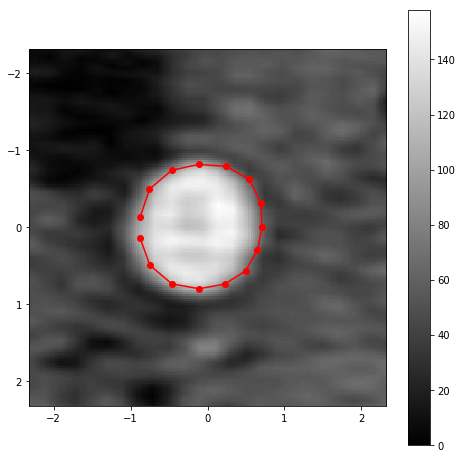

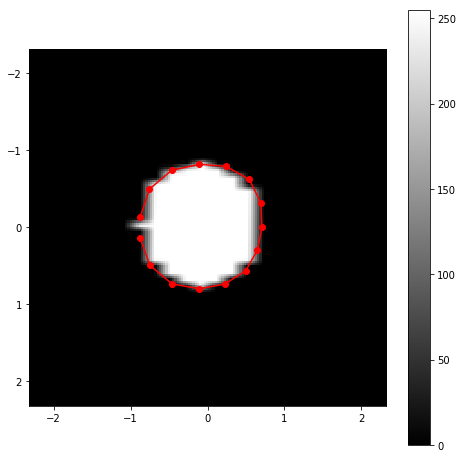

right_iliac path point 10


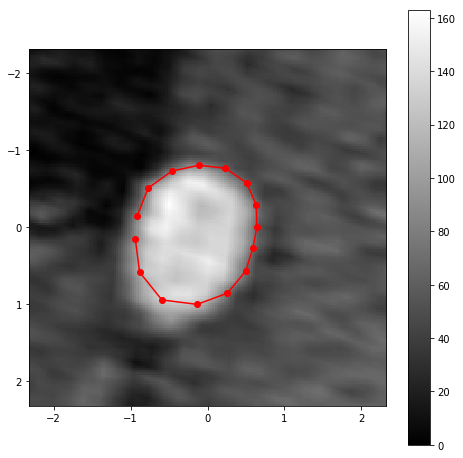

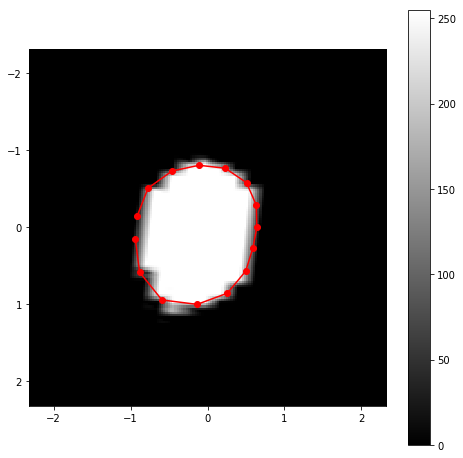

right_iliac path point 20


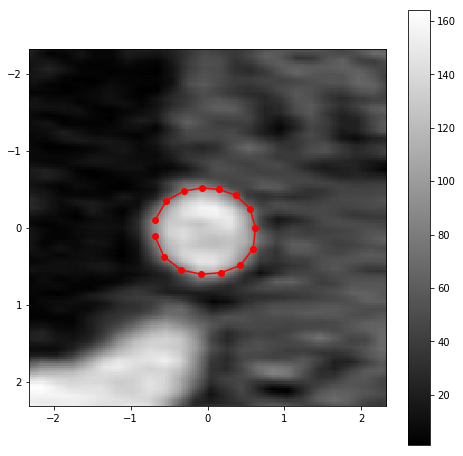

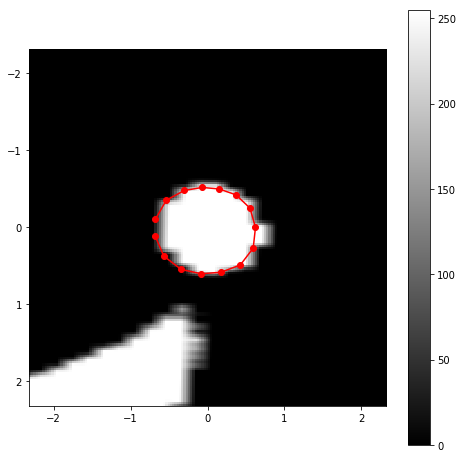

right_iliac path point 30


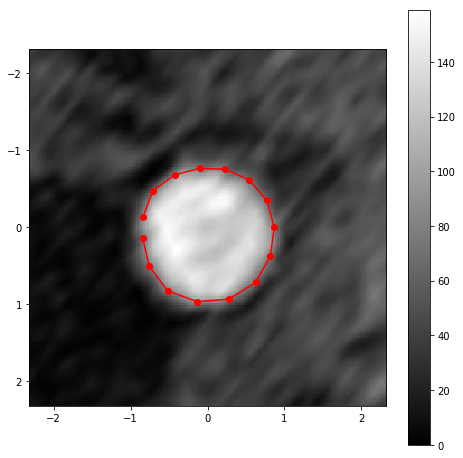

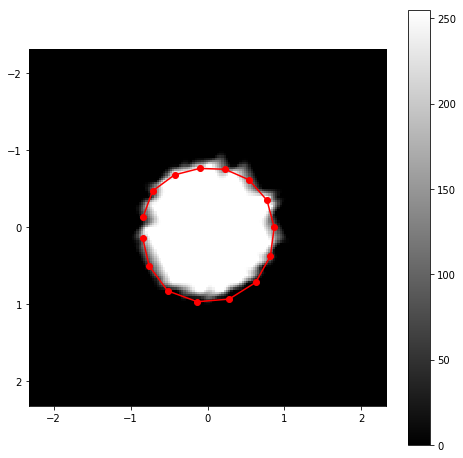

right_iliac path point 40


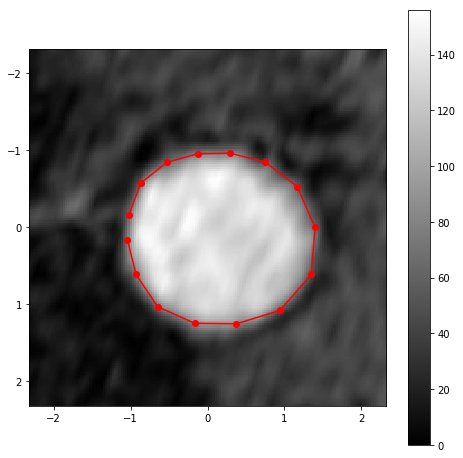

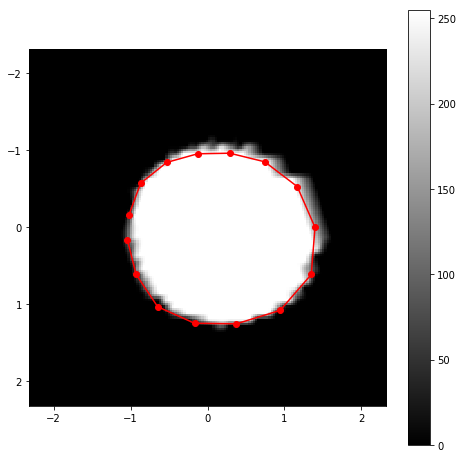

right_iliac path point 50


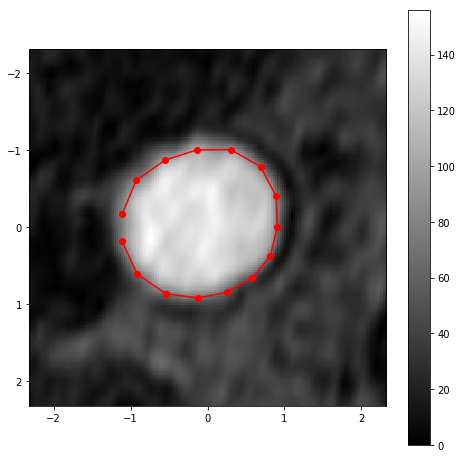

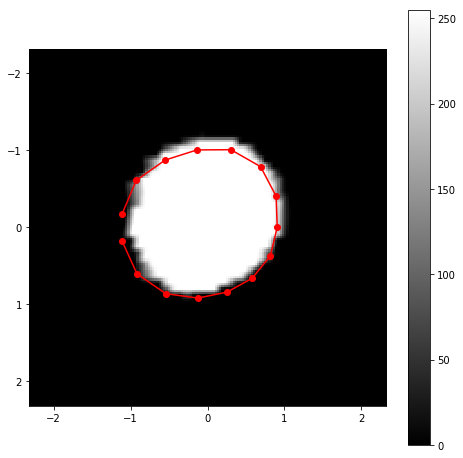

right_iliac path point 60


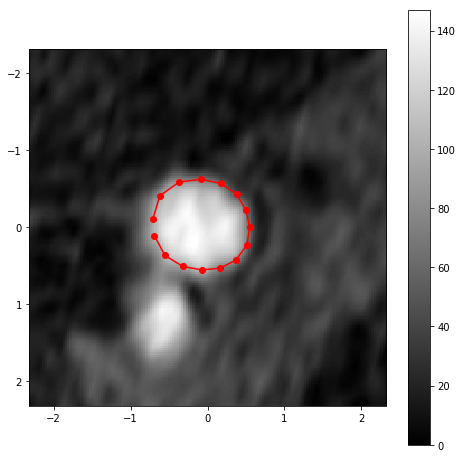

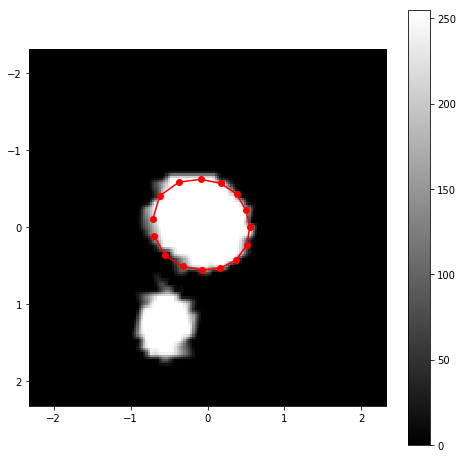

right_iliac path point 70


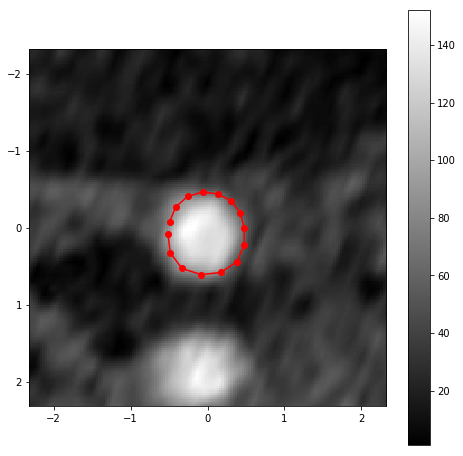

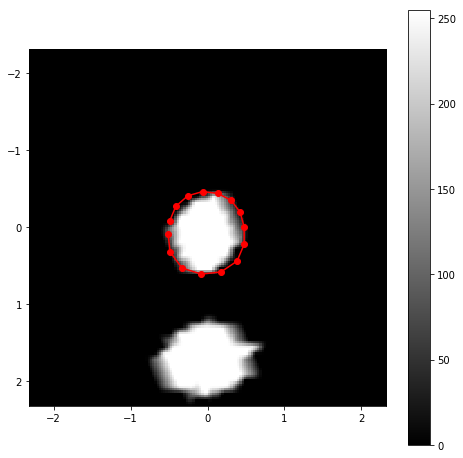

right_iliac path point 80


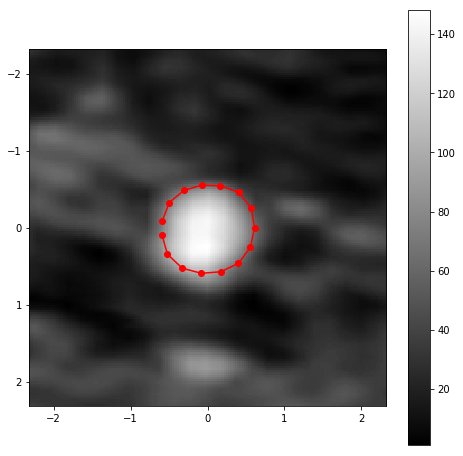

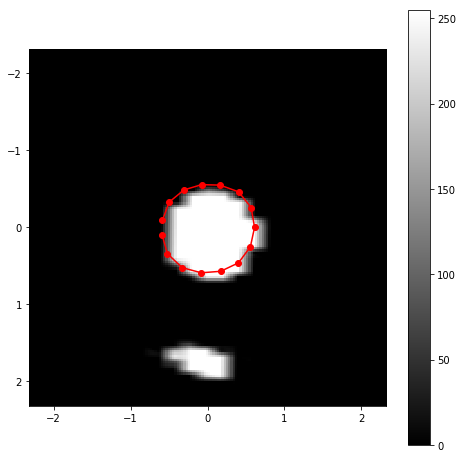

right_iliac path point 90


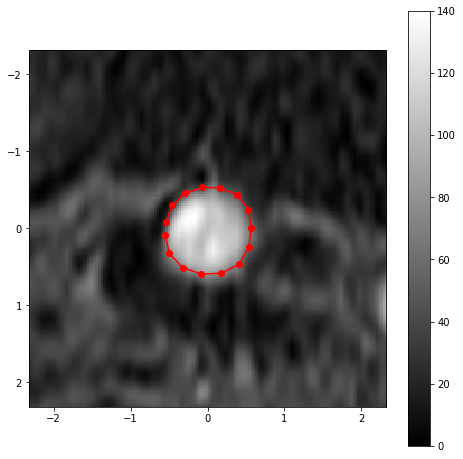

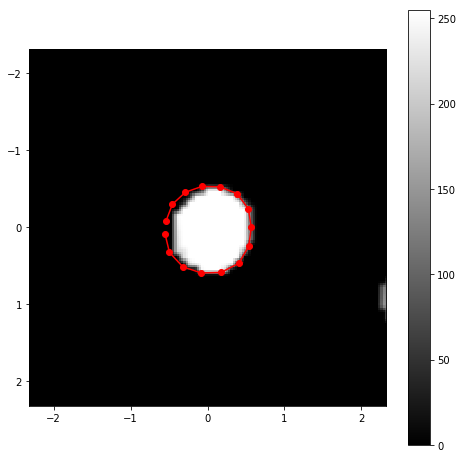

right_iliac path point 100


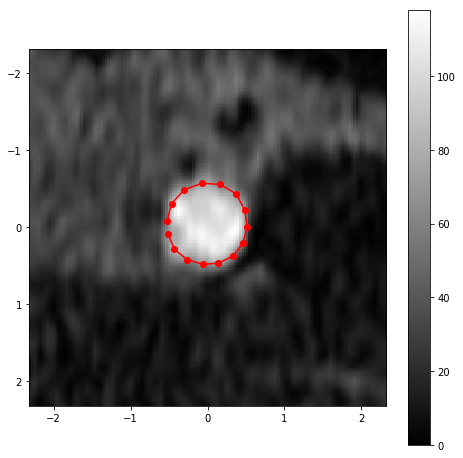

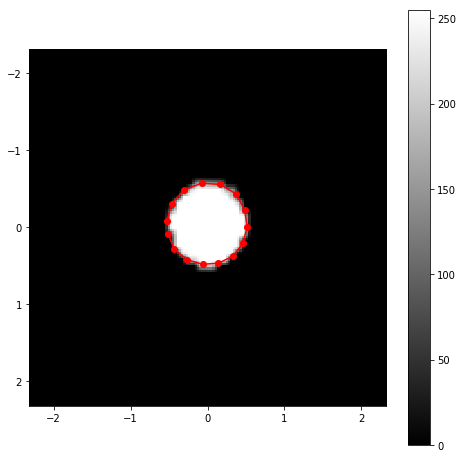

right_iliac path point 110


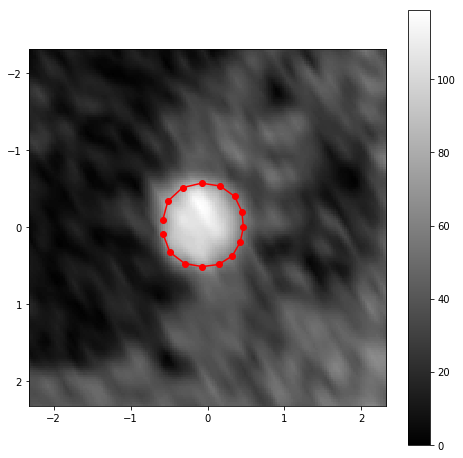

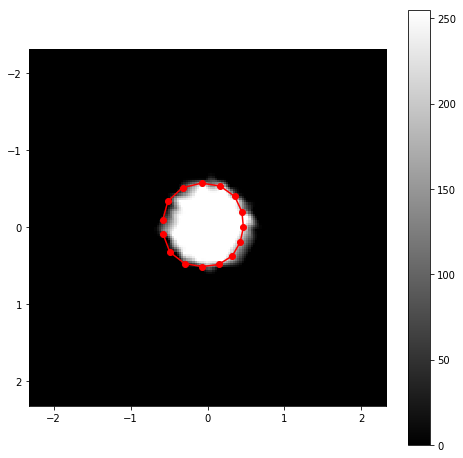

right_iliac path point 120


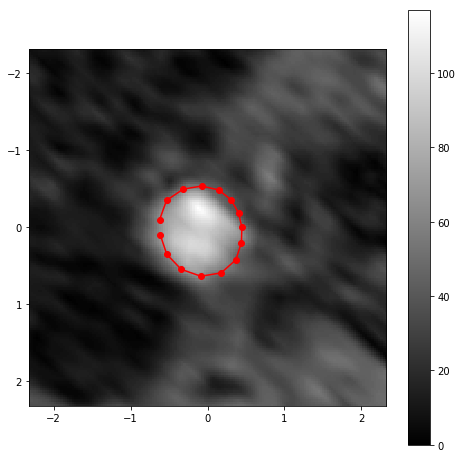

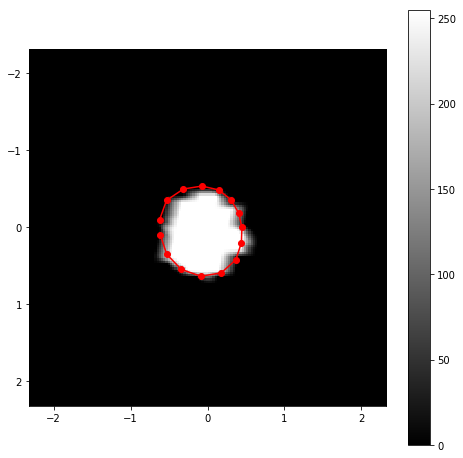

right_iliac path point 130


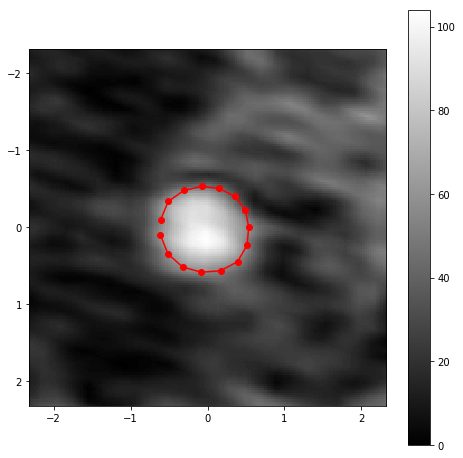

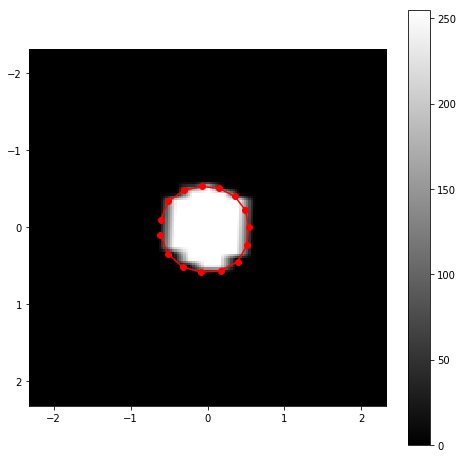

right_iliac path point 140


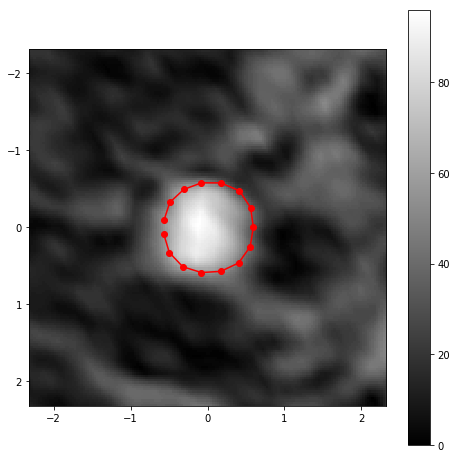

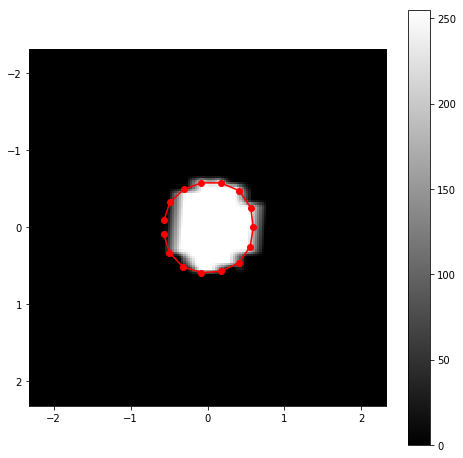

right_iliac path point 150


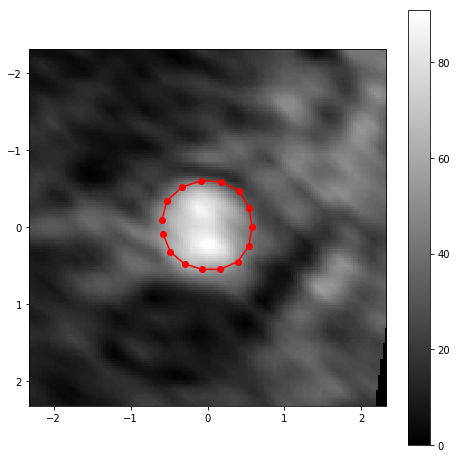

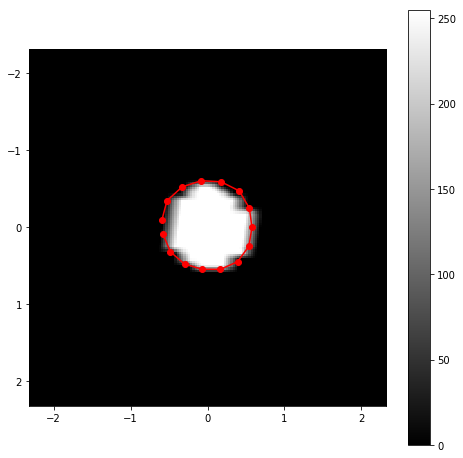

right_iliac path point 160


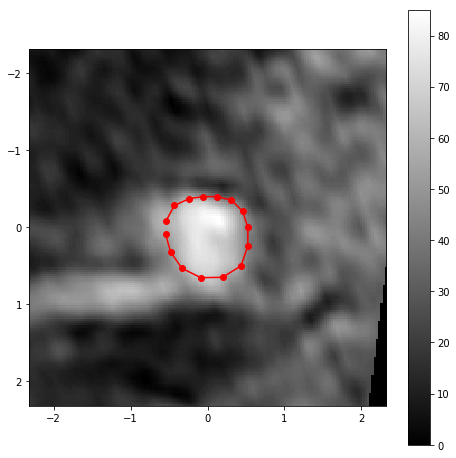

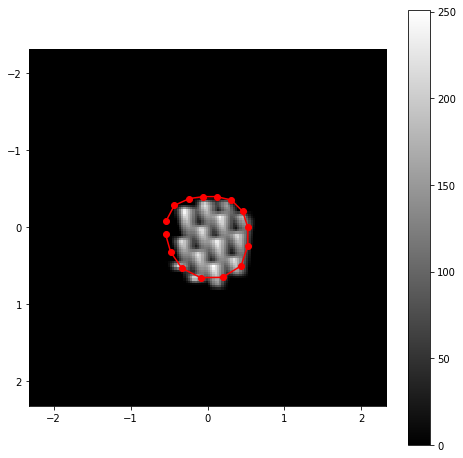

right_iliac path point 170


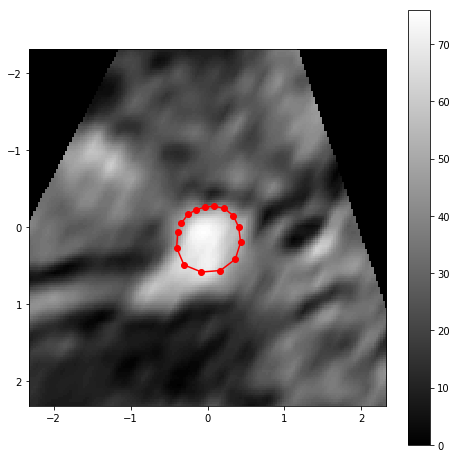

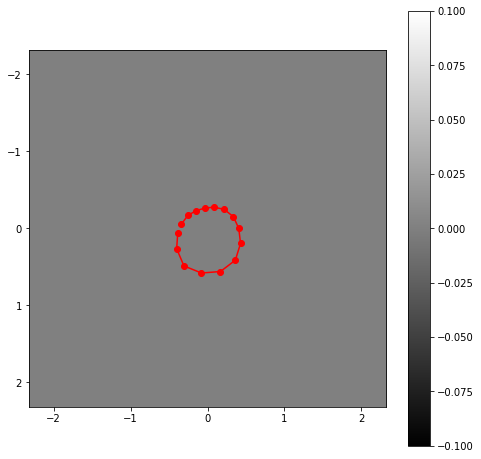

right_iliac path point 180


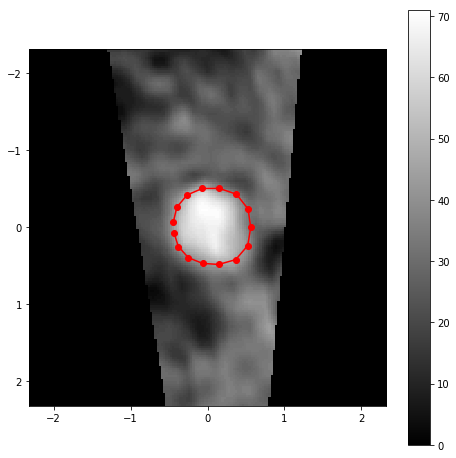

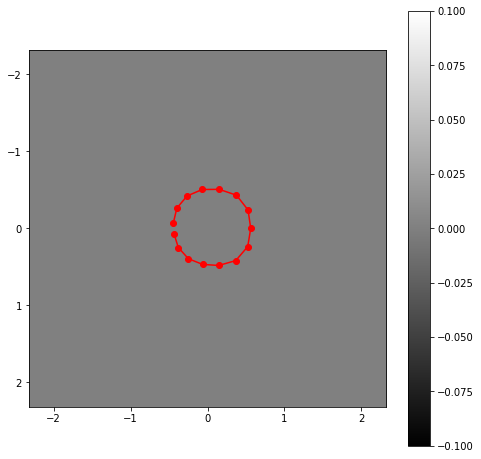

right_iliac path point 190


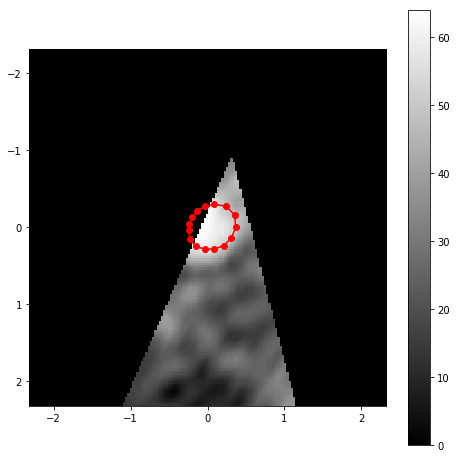

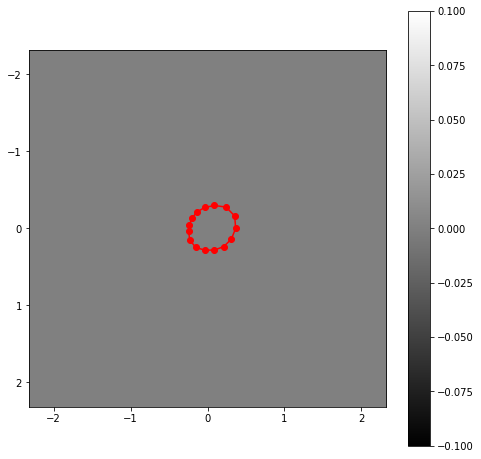

In [23]:
%matplotlib inline
INTERVAL = 10

contours_3d = []

for i in range(0, n_points, INTERVAL):
    print("{} path point {}".format(name,i))
    point = points[i]
    
    p = point[:3]
    n = point[3:6]
    v = point[6:9]
    
    x = image_sv.get_reslice(p,n,v)
    y = seg_sv.get_reslice(p,n,v)

    x_input      = preprocessor(x)
    
    yhat         = model.predict(x_input)
    
    pred_contour = postprocessor(yhat)
    
    c3d = vascular_data.denormalizeContour(pred_contour, p, n, v)
    contours_3d.append(c3d)
    
    plt.figure(figsize=(8,8))
    plt.imshow(x, extent=[-REAL_EXT,REAL_EXT,REAL_EXT,-REAL_EXT], cmap='gray')
    plt.colorbar()
    plt.plot(pred_contour[:,0], pred_contour[:,1], color='r', marker='o')
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(y, extent=[-REAL_EXT,REAL_EXT,REAL_EXT,-REAL_EXT], cmap='gray')
    plt.colorbar()
    plt.plot(pred_contour[:,0], pred_contour[:,1], color='r', marker='o')
    plt.show()

<IPython.core.display.Javascript object>


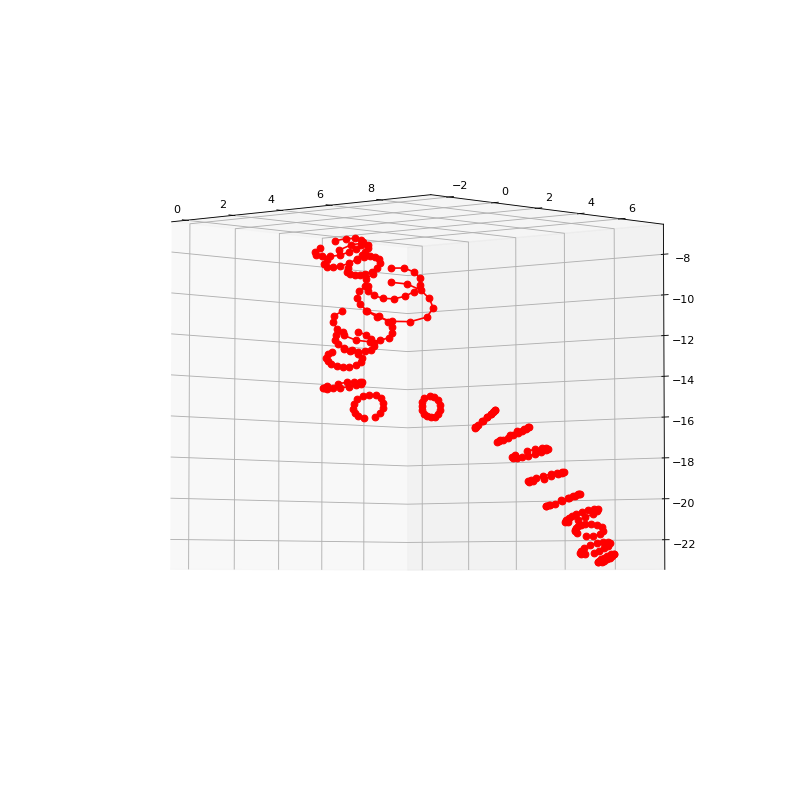

In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for c in contours_3d:
    ax.plot3D(c[:,0], c[:,1], c[:,2], color='r', marker='o')
    
plt.show()